In [31]:
import pandas as pd 
import numpy as np 

import seaborn as sn 
from seaborn import distplot
from seaborn import heatmap

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
 
# Scikit-Learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix


In [34]:
from google.colab import drive   # use if the dataset in your drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:

path = '/content/drive/My Drive/outliersRemoved.csv'  
raw_data = pd.read_csv(path)

In [33]:
kWhs = raw_data.iloc[:, 2:]  #seperate the features and the label
labels = raw_data.iloc[:, 1]

In [35]:
NUM_CONSUMERS, NUM_DAYS = kWhs.shape

print(NUM_CONSUMERS, NUM_DAYS)

42372 1034


Function to sacle data to try differant type of scaling and plote the data before and fter scaling

In [36]:

def scale_features(X=kWhs, scaling_strategy='Standard', plot_distributions=False):
  """Allows user to scale features for individual samples using specified scaling strategy.
  `Standard` - all features scaled to have mean 0, standard deviation of 1
  `MinMax` - all features scaled according to x - x_min / (x_max - x_min)
  `MaxAbs` - all features scaled according to x / abs(x_max)
  
  Returns matrix of scaled features as a numpy array.

  Also allows before/after plots of feature values to compare effect of scaling
  """
  # StandardScaler - all features will have mean of 0, and std deviation of 1
  if (scaling_strategy=='Standard'):
    # Instantiate a StandardScaler object
    scaler = StandardScaler()
  elif (scaling_strategy=='MinMax'):
    scaler = MinMaxScaler()
  elif (scaling_strategy=='MaxAbs'):
    scaler = MaxAbsScaler()

  # Make a copy of the features, transpose so that consumers become columns
  X_copy = X.copy().transpose()

  # Once consumers are in columns, scale each consumer using scaler object and retranspose results 
  # Retransposing ensures that in scaled data, the consumers are still rows
  X_scaled = scaler.fit_transform(X_copy).transpose() # THIS IS A NUMPY ARRAY, NOT A DATAFRAME

  # If the user has asked to compare distributions
  if plot_distributions:
    # First figure - before scaling
    plt.figure(figsize=(12, 6))
    distplot(X.values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Unscaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - Before Scaling', fontsize=18)

    # Second figure - after scaling
    plt.figure(figsize=(12, 6))
    distplot(X_scaled.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Scaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - After {} Scaling'.format(scaling_strategy), fontsize=18)

  # Return the scaled features
  return X_scaled

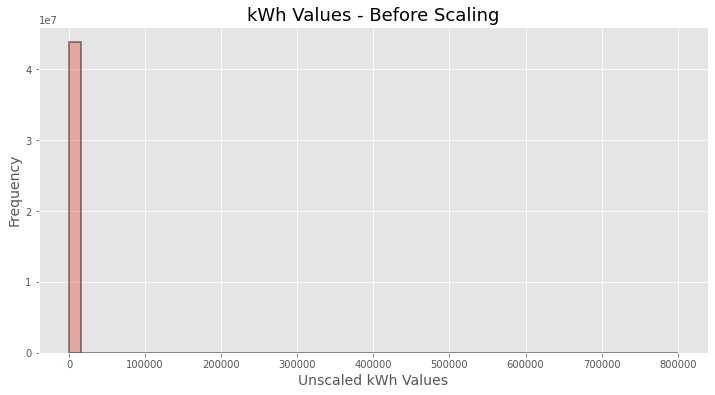

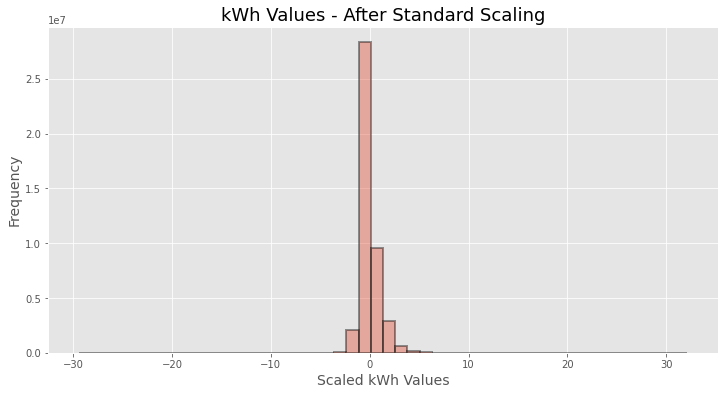

In [37]:
X_scaled_std = scale_features(X=kWhs,scaling_strategy='Standard', plot_distributions=True)

In [38]:
# Printing dimension of datatset for padding
NUM_DAYS = 1034
DAYS_PER_WEEK = 7
NUM_WEEKS_FLOAT = NUM_DAYS / DAYS_PER_WEEK 
NUM_WEEKS = int(np.ceil(NUM_WEEKS_FLOAT))
print(f"Number of days per dataset: {NUM_DAYS}.\nNumber of days per week: {DAYS_PER_WEEK}")
print(f"So exact number of weeks: {NUM_WEEKS_FLOAT}\nWhich, when rounded up is {NUM_WEEKS}")
print(f"Which means new number of days is: {NUM_WEEKS * DAYS_PER_WEEK}")
print(f"Extra days to add: {NUM_WEEKS * DAYS_PER_WEEK - NUM_DAYS}")

Number of days per dataset: 1034.
Number of days per week: 7
So exact number of weeks: 147.71428571428572
Which, when rounded up is 148
Which means new number of days is: 1036
Extra days to add: 2


In [39]:
# 2 extra days per consumer 
X_scaled_std_padded = np.append(X_scaled_std, np.zeros((NUM_CONSUMERS, 2)), 
                                axis=1)


In [40]:
# Are the last two columns (and only the last two columns) zero?
pd.DataFrame(X_scaled_std_padded)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035
0,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,...,0.063220,0.561141,0.028722,0.106917,0.284007,0.265608,-0.005776,1.212002,0.377151,0.432348,1.410940,0.350703,0.178213,-0.101220,-0.102370,-0.172516,-0.132269,0.049421,0.036771,0.133366,-0.032224,0.467996,0.387501,0.060920,-0.036824,-0.108120,0.100018,-0.154117,-0.054073,0.048271,0.050571,0.216161,-0.249562,0.126466,0.189712,-0.012676,0.173613,-0.104670,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,...,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,-0.455842,1.063820,2.583482,2.510596,2.087861,2.483264,1.863738,2.100616,2.171679,2.410379,2.588948,2.144347,2.126126,2.774806,2.763873,3.261317,1.539398,2.814893,2.793028,2.698276,3.450819,3.022617,2.926044,2.505130,2.131592,2.033197,0.0,0.0
3,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,-0.632350,...,0.146106,1.515245,0.695271,1.320867,-0.019021,0.310289,1.121771,0.951926,1.898339,0.754717,0.882101,1.641685,0.560339,0.391437,0.478247,0.597138,0.524483,0.845301,0.634882,0.785855,0.746225,0.685835,0.789629,0.699045,0.761322,0.473529,0.474473,0.498062,0.576380,0.794347,0.996274,0.774532,1.216129,1.329359,1.061381,1.184991,0.732071,0.473529,0.0,0.0
4,-0.897241,-0.435961,-0.208688,-0.826534,-0.777713,-0.484783,-0.589160,-0.765928,-0.791181,-0.809699,-0.744043,-0.614413,-0.786130,-0.669968,-0.735625,-0.791181,-0.811383,-1.242360,-1.237310,-0.744043,-0.289496,0.161683,-0.074007,-0.203637,-0.164917,-0.313065,-0.302964,-0.057172,-0.129563,-0.047071,-0.107678,-0.570641,-0.365254,-0.442695,-0.254143,-0.158183,-0.442695,-0.328217,-0.252459,-0.212055,...,0.399057,0.308148,0.431044,0.451246,1.606131,0.360337,0.888957,0.993335,1.550575,1.301416,0.665051,1.735761,0.877173,0.580876,0.154949,0.156633,0.330034,0.350236,-0.033603,0.311515,0.355286,0.506802,1.163369,1.032055,0.700405,0.358653,0.178518,-0.053805,1.006803,0.335084,0

In [41]:
# Creating a new numpy array to store the training dat
X_reshaped = np.zeros((NUM_CONSUMERS, NUM_WEEKS, DAYS_PER_WEEK,1))

In [42]:
def transform_daily_to_weekly(daily_kWhs):
  """Will simply reshape the 1D daily kWhs of a single consumer into 2D weekly data""" 
  return daily_kWhs.reshape(NUM_WEEKS, DAYS_PER_WEEK, 1)

In [43]:
# Applying this function to every consumer in the original dataset
# And saving the (148, 7) kWhs matrix for that consumer at the ith index in 3D array
for i in range(0, NUM_CONSUMERS):
  X_reshaped[i] = transform_daily_to_weekly(X_scaled_std_padded[i])

In [44]:
print(X_reshaped.shape)
X_reshaped[0]

(42372, 148, 7, 1)


array([[[-0.87972438],
        [-0.87972438],
        [-0.87972438],
        ...,
        [-0.87972438],
        [-0.87972438],
        [-0.87972438]],

       [[-0.87972438],
        [-0.87972438],
        [-0.87972438],
        ...,
        [-0.87972438],
        [-0.87972438],
        [-0.87972438]],

       [[-0.87972438],
        [-0.87972438],
        [-0.87972438],
        ...,
        [-0.87972438],
        [-0.87972438],
        [-0.87972438]],

       ...,

       [[ 0.13336578],
        [-0.03222444],
        [ 0.46799602],
        ...,
        [ 0.06092006],
        [-0.03682416],
        [-0.10811995]],

       [[ 0.10001775],
        [-0.15411724],
        [-0.05407315],
        ...,
        [ 0.05057067],
        [ 0.2161609 ],
        [-0.2495616 ]],

       [[ 0.12646619],
        [ 0.18971246],
        [-0.01267559],
        ...,
        [-0.10467016],
        [ 0.        ],
        [ 0.        ]]])

In [45]:
X_reshaped.shape
labels = np.asarray(labels)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=labels)

In [77]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(33897, 148, 7, 1) (8475, 148, 7, 1) (33897,) (8475,)
int64


In [80]:
def build_model():
  model = Sequential()

  #First conv layer
  model.add(Conv2D(filters = 18, kernel_size = (3,3), activation = 'tanh', input_shape = (148,7,1), padding ='same'))
  

  #second conv layer
  model.add(Conv2D(filters = 36, kernel_size = (3,3), activation = 'tanh',padding ='same')) 
  

  #Third conv layer
  model.add(Conv2D(filters = 72, kernel_size = (3,3), activation = 'tanh',padding ='same'))
  

  #Fourth conv layer
  model.add(Conv2D(filters = 144, kernel_size = (3,3), activation = 'tanh',padding ='same'))
  


  #Fifth conv layer
  model.add(Conv2D(filters = 288, kernel_size = (3,3), activation = 'tanh',padding ='same'))

  #model.add(Conv2D(filters = 576, kernel_size = (3,3), activation = 'tanh',padding ='same'))
  
  #Max Pooling Layer
  model.add(MaxPooling2D(pool_size = (3,3)))

  # Fully Connected layer
  model.add(Flatten())
  model.add(Dense(units=60, activation='relu'))
  model.add(Dense(units=1, activation='sigmoid'))


  # Compile with reasonable defaults for this problem
  model.compile(optimizer='sgd', 
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC()]
                  )
  
  return model


In [81]:
model = build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 148, 7, 36)        5868      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 148, 7, 72)        23400     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 148, 7, 144)       93456     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 148, 7, 288)       373536    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 2, 288)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 28224)            

In [82]:
# Fit the model, remember its training history
history = model.fit(X_train, y_train, 
                             batch_size=32, epochs=15,
                             validation_split=0.2, verbose = 1)

Epoch 1/15
848/848 [==============================] - 47s 56ms/step - loss: 0.2893 - auc_6: 0.6129 - val_loss: 0.2830 - val_auc_6: 0.6864
Epoch 2/15
848/848 [==============================] - 47s 55ms/step - loss: 0.2720 - auc_6: 0.6945 - val_loss: 0.2720 - val_auc_6: 0.7328
Epoch 3/15
848/848 [==============================] - 47s 55ms/step - loss: 0.2633 - auc_6: 0.7289 - val_loss: 0.2634 - val_auc_6: 0.7472
Epoch 4/15
848/848 [==============================] - 47s 55ms/step - loss: 0.2562 - auc_6: 0.7488 - val_loss: 0.2604 - val_auc_6: 0.7571
Epoch 5/15
848/848 [==============================] - 47s 55ms/step - loss: 0.2501 - auc_6: 0.7680 - val_loss: 0.2645 - val_auc_6: 0.7612
Epoch 6/15
848/848 [==============================] - 46s 55ms/step - loss: 0.2439 - auc_6: 0.7822 - val_loss: 0.2537 - val_auc_6: 0.7688
Epoch 7/15
848/848 [==============================] - 47s 55ms/step - loss: 0.2381 - auc_6: 0.7970 - val_loss: 0.2575 - val_auc_6: 0.7660
Epoch 8/15
848/848 [==============

In [52]:
def plot_history(history, model_name, has_metrics=False, metric_name=None, 
                 loss_metric=None):
  """Plots training and validation loss, as well as optional metric"""
  # Extract loss from the history object
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = np.arange(1, len(loss) + 1)

  # Create a new figure for plotting loss
  plt.figure(figsize=(12, 6))
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs', fontsize=14)
  plt.ylabel('Loss' if loss_metric is not None else loss_metric, fontsize=14)
  plt.title('Training vs Validation Loss \n{}'.format('' if model_name is None else model_name), 
            fontsize=18)
  plt.legend()

  # If the user has also asked to plot a metric
  if has_metrics and metric_name is not None:
    # Create a new figure for plotting the metric
    plt.figure(figsize=(12, 6))
    metric = history.history[metric_name]
    val_metric = history.history['val_{}'.format_metric_name]
    
    plt.plot(epochs, metric, label='Training')
    plt.plot(epochs, val_metric, label='Validation')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.title('Training vs Validation Loss {}'.format(metric_name), fontsize=18)
    plt.legend()

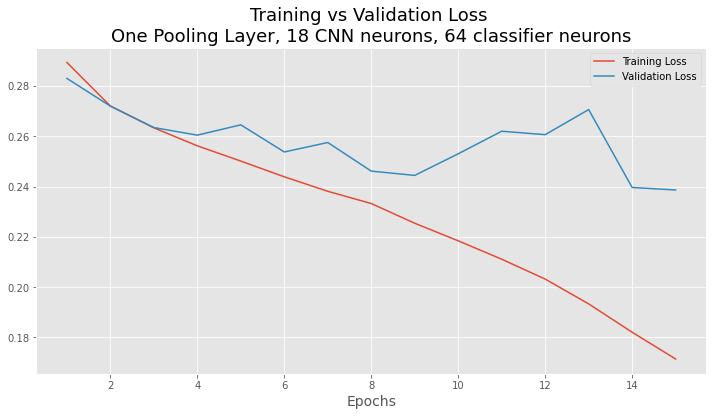

In [83]:
plot_history(history=history, 
             model_name='One Pooling Layer,  60 classifier neurons')


In [84]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, roc_curve, confusion_matrix

In [85]:
_, X_val, _, y_val = train_test_split(X_train, y_train,   # Splitting training data
                                      stratify=y_train,
                                      random_state=42,    # Different from previous split
                                      shuffle=True, 
                                      test_size=0.2)

In [89]:
def get_classification_result(model, X_test, y_true, model_name=None, 
                              normalize_conf_mat='all'):
  """Displays classification report, confusion matrix, and ROC curve for a trained
  model using classification results on data provided"""
  # PREDICTIONS
  # First, get the predictions for the test data
  y_pred = model.predict_classes(X_test)

  # CLASSIFICATION REPORT
  print("classification report".upper(), end='\n')
  print(classification_report(y_true, y_pred, labels=[0, 1], 
                              target_names=['Regular Consumer', 'Thief']))
  
  # CONFUSION MATRIX
  if (normalize_conf_mat=='rows'):
    normalize='true'
  elif (normalize_conf_mat=='cols'):
    normalize='pred'
  else:
    normalize='all'

  # Using Seaborn to plot confusion matrix as a heatmap 
  conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize)

  # Create a heatmap in lieu of the plot_confusion_matrix call in sklearn
  plt.figure(figsize=(8, 8))
  heatmap(conf_mat, annot=True, fmt='.5g', cmap='Blues', 
        xticklabels=['Predicted Reg', 'Predicted Thief'], 
        yticklabels=['True Reg', 'True Thief'])
  plt.title('Confusion Matrix ' + ('' if model_name is None else ' - ' + model_name))

  # ROC Curve
  plt.figure(figsize=(8, 8))
  y_pred_keras = model.predict(X_test).ravel()
  fpr, tpr, _ = roc_curve(y_true, y_pred_keras, pos_label=1)
  roc_auc = roc_auc_score(y_true, y_pred_keras)
  plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
  plt.xlabel('False Positive Rate', fontsize=14)
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.title('ROC Curve' + ('' if model_name is None else (' - ' + model_name)))
  plt.legend(loc='lower right')

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.94      1.00      0.97      6202
           Thief       0.89      0.36      0.51       578

        accuracy                           0.94      6780
       macro avg       0.92      0.68      0.74      6780
    weighted avg       0.94      0.94      0.93      6780



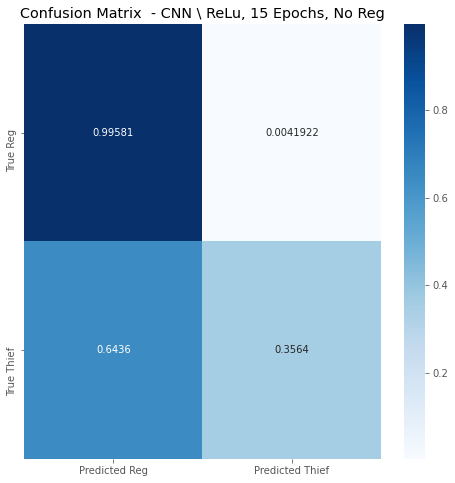

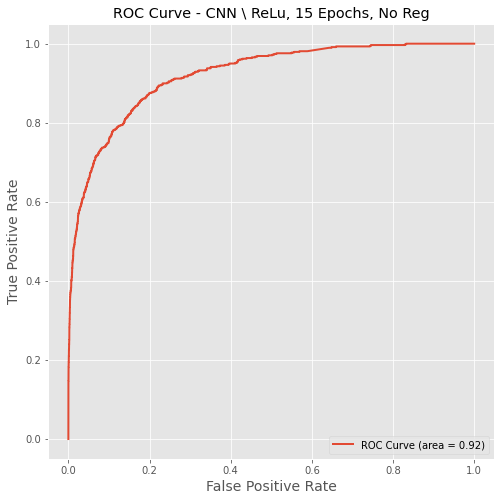

In [91]:

get_classification_result(model=model, X_test=X_val, y_true=y_val,
                          model_name='CNN \ ReLu, 15 Epochs, No Reg', 
                          normalize_conf_mat='rows')